# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

You will have to install 'progressbar2' package as well.
In the same terminal run the following command.

* conda install -c conda-forge progressbar2

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Import the data and libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import progressbar
import re
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer

# read in the json files and convert to dataframes
portfolio = pd.DataFrame(pd.read_json('data/portfolio.json', orient='records', lines=True))
profile = pd.DataFrame(pd.read_json('data/profile.json', orient='records', lines=True))
transcript = pd.DataFrame(pd.read_json('data/transcript.json', orient='records', lines=True))

## Objective:
Objective of this project is to build a model to predict whether or not a customer will respond to an offer, and which features are most significant in making the prediction

## Strategy:
I am planning to combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. An offer would be successful if it was viewed and completed before its duration ends. I am planning to build classification models to predict the people who might or might not respond to an offer. I am going to compare the performance of these models with a naive model that assumes all offers were successful. I am planning to use accuracy and f1-score parameters. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics", hence it balances a model’s exactness as well as completeness. I am also planning refine the parameters of the model that has the highest accuracy and F1-score in order to improve its performance furthermore.

## Exploratory Data Analysis and Data Cleaning

### 1a. Offer Portfolio Data

In [2]:
# Look at portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# Check for missing values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
# Check unique offer ids in the data
portfolio['id'].nunique()

10

In [5]:
# Check how many offers there are of each type
portfolio.groupby('offer_type').count()['id']

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

<b>Findings</b>: The portfolio data doesn't have any missing data. The 'channels' column has lists as values, so might need to convert them to binaries for future analysis and modeling. Also, 'difficulty' and 'reward' columns are dollar amounts and 'duration' is in days, so we will need to normalize it for modeling.

### 1b. Clean Portfolio data
1. One hot encode channels and offer_type columns
2. Rename id column to offer_id to avoid further confusion after we merge all datasets.

In [6]:
# Rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [7]:
# Convert offer_type catrgories to binary columns
portfolio = pd.get_dummies(portfolio, columns= ['offer_type'], prefix= 'offer_type')
portfolio.head()

,channels,difficulty,duration,offer_id,reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0


In [8]:
# Find out unique channel values from channels column and convert the list column into multiple columns
unique_cahnnels = list(set.union(*portfolio['channels'].apply(set)))

for index, row in portfolio.iterrows():
    for channel in unique_cahnnels:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)
portfolio.head()

,difficulty,duration,offer_id,reward,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1.0,1.0,0.0,1.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1.0,1.0,1.0,1.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,0.0,1.0,1.0,1.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,0.0,1.0,1.0,1.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,0.0,0.0,1.0,1.0


### 2a. Profile / Demographic Data

In [9]:
# Look at the profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# Check for missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
# Check the distributions
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
# Check the rows for 'age' = 118
print(profile[profile.age == 118].head())
# Dig down deeper for 'gender' and 'income' columns since all values are missing.
print(profile[profile.age == 118].gender.unique())
print(profile[profile.age == 118].income.unique())

   age  became_member_on gender                                id  income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN
[None]
[ nan]


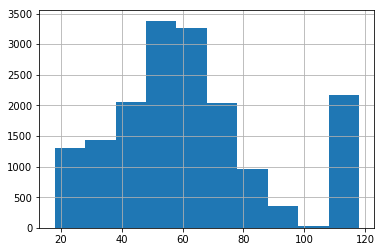

In [13]:
# Plot age distribution
profile['age'].hist();

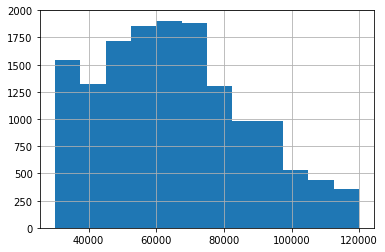

In [14]:
# Plot income distribution
profile['income'].hist(bins=12);

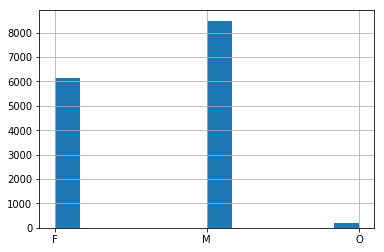

In [15]:
# Plot gender distribution
profile['gender'].hist(bins=12);

In [16]:
# Check how many unique people are in dataset
profile['id'].nunique()

17000

<b>Findings:</b> There are total 17000 people in the data. There are null values in 'gender' and 'income' columns and further digging down shows that these missing values are associated with 'age' = 118. So these rows are outliers which need to be dropped. 'became_member_on' column shows there are members between 2013 and 2018. It would be interesting to see how new and old members might react to offers.

### 2b. Clean Profile data
1. Rename id col name to customer_id.
2. Create readable date format in became_member_on column.
3. Drop rows with no gender, income data (per above analysis associated with age = 118)
5. Convert gender values to numeric 0s and 1s
6. Add start year and start month columns (for further analysis)

In [17]:
# Rename id col name customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [18]:
# Convert into date time format
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [19]:
# Drop rows where gender is null, (these are same rows where income is null and age is 118)
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [20]:
# Check if all missing gender and income values are dropped 
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [21]:
profile.gender.value_counts()/ profile.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [22]:
# Convert gender values to numeric 0s and 1s, 0.01 % records with unknown gender will be treated as women, but it is a small proportion
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [23]:
# Add start_year and start_month columns
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

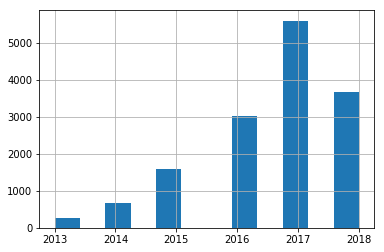

In [24]:
# Plot membership by year
profile['start_year'].hist(bins = 12);

### 3a. Transaction Data

In [25]:
# Look at transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
# Check unique persons in the transcript data
print("Number of records in transcript file: ", transcript.shape[0])
print("Number of unique people in transcript file: ", transcript.person.nunique())

Number of records in transcript file:  306534
Number of unique people in transcript file:  17000


In [27]:
# Check for missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [28]:
# Sort the data by person and event to see how value column is formatted
transcript.sort_values(['person', 'event'])

,event,person,time,value
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
247879,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


<b>Findings:</b> There are no missing values in the data. The 'value' column is in dictionary format, so the values need to be extracted into separate columns and cleaned up. 'event' column also needs to be converted to binary.

### 3b Clean the Transcript data
1. Rename person col name to customer_id.
2. Create separate columns for amount and offer_id from value col.
3. Drop transaction rows whose customer_id is not in profile:customer_id
4. Convert time from hours to days
5. Segregate offer and transaction data
6. Drop duplicates

In [29]:
# Rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [30]:
# Create separate columns for amount and offer_id from value col.
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# Change amount column type to float
transcript.amount.astype('float')

# Drop value column
transcript.drop(columns=['value'], inplace=True)

In [31]:
# Drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [32]:
# Convert time to days
transcript['time'] /= 24.0

In [33]:
# Drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [34]:
# Separate offer and transaction data  
transaction = transcript[transcript.event=='transaction'].copy()
# Create transaction dataframe and drop offer related columns
transaction.drop(columns=['offer_id', 'event'], inplace=True)
transaction.head()

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
11032,54890f68699049c2a04d415abc25e717,0.0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [35]:
# Create offers data and convert event categorical column into binary columns
offers = transcript[transcript.event!='transaction'].copy()
offers = pd.get_dummies(offers, columns= ['event'], prefix= 'event')
offers.head()

,customer_id,time,offer_id,amount,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0


In [36]:
# Drop the amount column since they have all NaNs
offers.drop('amount', axis = 1, inplace = True)
offers.head()

,customer_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


## Data Preprocessing

In [37]:
# Function to combine profile, portfolio, transaction and offers data

def combine_data(profile, portfolio, offers, transaction):
    data = []
    customer_ids = offers['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers
        cust_offer_data = offers[offers['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions
        cust_transaction_data = transaction[transaction['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['event_offer received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['event_offer completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['event_offer viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # extract offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # extract offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [38]:
if (0 == 1):
    data = combine_data(profile, portfolio, offers, transaction)

In [39]:
# Write the data into a csv file for future use, since combining the data takes aroud 13 minutes
if (0 == 1):
    data.to_csv('.csv', index=False)

In [40]:
data = pd.read_csv('data/combined_data.csv')

In [41]:
# Make data more intuitive by reordering columns
reordered_cols = ['customer_id', 'age', 'gender', 'income', 'became_member_on', 
                 'start_year', 'start_month', 'offer_id', 'difficulty', 'reward',
                 'duration', 'offer_type_bogo', 'offer_type_discount', 
                 'offer_type_informational', 'offer_successful', 'email', 'web', 
                 'social', 'mobile', 'time', 'total_amount'
                 ]

data = data[reordered_cols]
data.head()

,customer_id,age,gender,income,became_member_on,start_year,start_month,offer_id,difficulty,reward,...,offer_type_bogo,offer_type_discount,offer_type_informational,offer_successful,email,web,social,mobile,time,total_amount
0,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,2017-05-09,2017,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,...,1,0,0,1,1.0,1.0,0.0,1.0,0.0,37.67
1,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,2017-05-09,2017,5,5a8bc65990b245e5a138643cd4eb9837,0,0,...,0,0,1,0,1.0,0.0,1.0,1.0,7.0,49.39
2,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,2017-05-09,2017,5,ae264e3637204a6fb9bb56bc8210ddfd,10,10,...,1,0,0,1,1.0,0.0,1.0,1.0,17.0,48.28
3,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,2017-05-09,2017,5,f19421c1d4aa40978ebb69ca19b0e20d,5,5,...,1,0,0,1,1.0,1.0,1.0,1.0,21.0,48.28
4,e2127556f4f64592b11af22de27a7932,68,1,70000.0,2018-04-26,2018,4,2906b810c7d4411798c6938adc9daaa5,10,2,...,0,1,0,0,1.0,1.0,0.0,1.0,0.0,0.00


In [42]:
data = data.drop(columns=['time', 'customer_id', 'email', 'offer_type_informational', 'became_member_on'])
data.head()

,age,gender,income,start_year,start_month,offer_id,difficulty,reward,duration,offer_type_bogo,offer_type_discount,offer_successful,web,social,mobile,total_amount
0,75,0,100000.0,2017,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,1,1.0,0.0,1.0,37.67
1,75,0,100000.0,2017,5,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,0,0.0,1.0,1.0,49.39
2,75,0,100000.0,2017,5,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,1,0.0,1.0,1.0,48.28
3,75,0,100000.0,2017,5,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,1,1.0,1.0,1.0,48.28
4,68,1,70000.0,2018,4,2906b810c7d4411798c6938adc9daaa5,10,2,7,0,1,0,1.0,0.0,1.0,0.00


In [43]:
# Calculate success proportion for each offer
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [44]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,difficulty,duration,reward,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,10,10,2,0,1,0,1.0,1.0,1.0,1.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,7,7,3,0,1,0,1.0,1.0,1.0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1,0,0,1.0,1.0,1.0,1.0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,7,10,1,0,0,1.0,1.0,0.0,1.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,5,10,1,0,0,1.0,1.0,1.0,1.0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,7,5,1,0,0,0.0,1.0,1.0,1.0
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,10,7,2,0,1,0,0.0,1.0,1.0,1.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,20,10,5,0,1,0,0.0,0.0,1.0,1.0
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,4,0,0,0,1,0.0,1.0,1.0,1.0
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,3,0,0,0,1,1.0,1.0,0.0,1.0


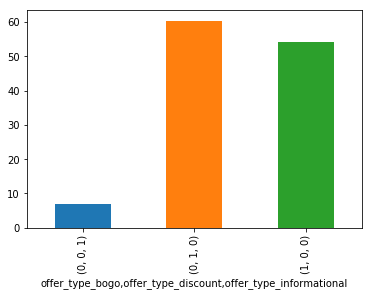

In [45]:
# Plot success rates for each offer type
percent_success.groupby(['offer_type_bogo', 
                         'offer_type_discount', 
                         'offer_type_informational'])['percent_success'].mean().plot(kind = 'bar');

54% of the 'bogo' offers are successful, while 60% of the discount offers are successful in terms of conversions. 

## Modeling:
We only need to split the data into train and test sets before building the models. As we are planning to implement logistic regression and random forest classifiers, both of these algorithms don't require variable scaling.

In [46]:
# Split the data into train and test sets

# Features that influence the label variable
features = data.drop(columns=['offer_successful'])

# Label variable to predict
label = data.filter(['offer_successful'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 5]
total_amount_train = X_train[:, 14]
X_train = X_train[:, [0,1,2,3,4,6,7,8,9,10,11,12,13]].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 5]
total_amount_test = X_test[:, 14]
X_test = X_test[:, [0,1,2,3,4,6,7,8,9,10,11,12,13]].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

## Naive Predictor

In [47]:
# Naive Predictor Performance
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.2f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.2f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.47
Naive predictor f1-score: 0.64


## Logistic Regression

### Build Model

In [48]:
scorer = make_scorer(fbeta_score, beta=0.5)

# Instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# Construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# Fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total= 1.2min
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total= 1.2min
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.7s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.7s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.4s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

### Performance

In [49]:
# Function to compute accuracya nd f1 score
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [50]:
# Evaluate logistic regression model's performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.698
LogisticRegression model f1-score: 0.693


(0.69783029001074115, 0.69331065759637189)

In [51]:
# Evaluate performance on test data
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.702
RandomizedSearchCV model f1-score: 0.698


(0.7016690892687083, 0.69756097560975616)

## Random Forest Classifier

### Build Model

In [52]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.9min


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  19.9s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=8 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  19.8s
[CV] n_estimators=150, min_samples_split=10, min_samples_lea

[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   4.2s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=3, total=   4.1s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  16.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=5, total=  16.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_featu

[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=6, total=   6.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   0.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=au

[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 10.4min


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.0s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.0s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.5s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=

[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  21.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=  21.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   2.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   2.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sq

[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  29.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, total=  29.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=4, total=   4.7s
[CV] n_estimators=200, min_samples_split=2, min_sampl

[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=   8.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.5s
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.4s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   5.4s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=4 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_fe

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 20.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

### Model Performance

In [53]:
# Evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.761
RandomForestClassifier model f1-score: 0.752


(0.76126745435016108, 0.75169254831862364)

In [54]:
# Evaluate performance on test data
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.738
RandomForestClassifier model f1-score: 0.729


(0.73845922510149864, 0.72907580477673939)

## Best Predictors in identifying responsiveness of a customer/ Feature Importance

Text(0.5,1,'Random Forest Estimated Feature Importance')

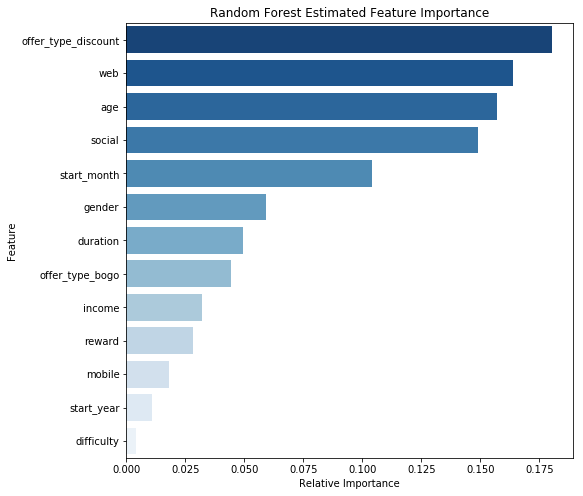

In [55]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

variable_names = set(features.columns) - set(['offer_id', 'total_amount'])

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

## Result and Improvements Discussion
Results suggest that the random forest model has the best training data accuracy and F1-score. A logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers. Apparently, the decision boundary between customers who respond to the offer and customers who don't is non-linear. Hence, the ensemble random forest is working better for this data.

Random forest is a combination of multiple decision trees. A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using majority voting. A consequence of this model construction strategy is that the depth of decision trees generated during random forest model training is typically large. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples. And that is evident from the accuracy of the model on test data.

## Refine the best model

In [56]:
# Print the Best Model's Hyperparameters¶
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [57]:
# Refine model hyperparameter space
parameters = {'n_estimators': [300, 350, 400, 450, 500],
              'max_depth': [10, 11, 12, 13, 14, 15],
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': [42]}

grid_obj = GridSearchCV(rf_clf,
                        parameters,
                        scoring=scorer,
                        cv=5,
                        n_jobs=3,
                        verbose=2)

grid_fit = grid_obj.fit(X_train,
                        y_train)

# dump(grid_fit, grid_fit_path)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42 
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  30.1s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  30.3s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  30.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=10, min_samples_leaf

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  9.0min


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42, total=  40.4s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42, total=  40.5s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42, total=  41.0s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42, total=  41.0s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42, total=  41.0s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42, total=  50.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42, total=  30.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42, total=  30.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42, total=  30.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42, total=  30.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimat

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42, total=  45.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42, total=  46.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42, total=  46.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42, total=  46.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42, total=  46.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42, total=  35.4s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42 


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 41.0min


[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42, total=  35.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42, total=  35.4s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42, total=  35.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42, total=  35.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42, total=  40.9s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimato

[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  57.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  57.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  57.5s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  56.9s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42, total=  34.1s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_est

[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  45.2s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  45.2s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  45.7s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  46.0s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimators=450, random_state=42, total=  51.7s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=2, n_estimato

[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  34.4s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  34.2s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  34.4s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  35.5s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=11, min_samples_leaf=1, min_samples_split=10, n_estimators=350, random_state=42, total=  42.2s
[CV] max_depth=11, min_samples_leaf=1, min_samples_split=10, 

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  50.7s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  50.9s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  51.0s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  50.8s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42, total=  56.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  37.9s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  38.4s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  38.3s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42 


[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 99.4min


[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  38.6s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42, total=  43.8s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42, total=  43.9s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42, total=  44.2s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=42, total=  44.1s
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=10, 

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42, total=  54.7s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42, total=  32.9s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42, total=  33.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42, total=  33.2s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimators=300, random_state=42, total=  33.0s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=5, n_estimato

[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42, total=  44.5s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42, total=  50.0s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42, total=  50.3s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42, total=  50.3s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=500, random_state=42 
[CV]  max_depth=11, min_samples_leaf=4, min_samples_split=10, n_estimators=450, random_state=42, total=  50.1s
[CV] max_depth=11, min_samples_leaf=4, min_samples_split=10, 

[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42, total=  36.0s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42, total=  41.6s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42, total=  41.7s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42, total=  41.7s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimators=350, random_state=42, total=  41.4s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42, total=  51.6s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42, total=  57.1s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42, total=  57.6s
[CV] max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42, total=  56.9s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=12, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=42, total=  57.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=2, n_

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  40.1s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  46.0s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  46.0s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  45.8s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  46.4s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  34.2s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=42, total=  57.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  33.8s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  33.7s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  34.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=2, n_estimat

[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=42, total=  46.6s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  52.7s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  53.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 


[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 183.2min


[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  53.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  53.5s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  52.7s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  58.5s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimators=500, random_state=42, total=  59.0s
[CV] max_depth=12, min_samples_leaf=4, min_samples_split=5, n_estimato

[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42, total=  45.1s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42, total=  44.5s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42, total=  44.4s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  51.0s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimators=400, random_state=42, total=  50.4s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=2, n_estimato

[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42, total= 1.0min
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  37.0s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42, total= 1.0min
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=13, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42, total=  37.1s
[CV] max_depth=13, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42, total=  50.0s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42, total=  50.1s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42, total=  50.2s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  56.4s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimators=450, random_state=42, total=  56.5s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42, total=  36.9s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42, total=  36.8s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42, total=  37.3s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  43.4s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=13, min_samples_leaf=2, min_samples_split=10, n_estimators=350, random_state=42, total=  43.6s
[CV] max_depth=13, min_samples_leaf=2, min_samples_split=10, 

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42, total=  55.6s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42, total=  54.6s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42, total=  54.6s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42, total= 1.0min
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42, total= 1.0min
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimato

[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42, total=  41.0s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42, total=  40.8s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42, total=  40.5s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42, total=  46.6s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42 
[CV]  max_depth=13, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42, total=  46.7s
[CV] max_depth=13, min_samples_leaf=4, min_samples_split=10, 

[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42, total=  38.8s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42, total=  38.7s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=42, total=  50.1s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=42, total=  50.3s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=400, random_state=42, total=  49.6s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42, total=  56.4s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=1, min_samples_split=10, n_estimators=450, random_state=42, total=  56.6s
[CV] max_depth=14, min_samples_leaf=1, min_samples_split=10, 

[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=42, total=  38.1s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=42, total=  38.1s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=42, total=  38.2s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  45.0s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  44.9s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimato

[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 300.3min


[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  45.1s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  45.2s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=350, random_state=42, total=  45.4s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  52.1s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, total=  51.5s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=42, total= 1.1min
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  38.7s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estimators=300, random_state=42, total=  39.1s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=2, n_estim

[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=42, total=  51.8s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=42, total=  52.3s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=400, random_state=42, total=  52.9s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  59.9s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42 
[CV]  max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=450, random_state=42, total=  59.8s
[CV] max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimato

[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  42.4s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  42.5s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42, total=  42.0s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42, total=  49.2s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=350, random_state=42, total=  49.1s
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimato

[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=42, total= 1.0min
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=42, total= 1.0min
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=450, random_state=42, total= 1.0min
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42, total= 1.2min
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42 
[CV]  max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42, total= 1.2min
[CV] max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=42, total=  48.4s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=42, total=  48.7s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=350, random_state=42, total=  48.5s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42, total=  55.5s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=400, random_state=42, total=  55.3s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=42, total= 1.2min
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=42, total= 1.2min
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=500, random_state=42, total= 1.2min
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42, total=  41.3s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42, total=  40.5s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_e

[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42, total=  53.0s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42, total=  53.1s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=400, random_state=42, total=  52.9s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42, total=  59.9s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=450, random_state=42, total=  59.8s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimato

[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42, total=  39.6s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42, total=  39.6s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42, total=  39.5s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42, total=  46.4s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42 
[CV]  max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=350, random_state=42, total=  46.3s
[CV] max_depth=15, min_samples_leaf=4, min_samples_split=10, 

[Parallel(n_jobs=3)]: Done 1350 out of 1350 | elapsed: 420.0min finished


NameError: name 'dump' is not defined

In [58]:
# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.810
RandomForestClassifier model f1-score: 0.800


(0.81007518796992484, 0.79989135601276573)

In [59]:
# Print the Refined Random Forest Model's Hyperparameters
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
# Evaluate performance of best model on test data
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.737
RandomForestClassifier model f1-score: 0.724


(0.73730640068167008, 0.72359052792574219)

## Conclusion

* In this project, I built a model that predicts whether or not a customer will respond to an offer.


* The cleaning stage included: converting categorical columns to binary columns, removing outliers. missing data, cleaning date and time formats, extracting values from a dict column into separate columns.


* The preprocessing stage included: separating transactions and offers data, combining offer portfolio, customer profile, and transaction data.


* Modeling stage included: 1. Finding out the accuracy and F1-score of a naive model that assumes all offers were successful.2. Buidling and comparing performance of a logistic regression and random forest model. 3. Finding out most important features in these predictions.


* Random forest model has the best training data and test data accuracy and F1-score:
   
    * Training data:
        * RandomForestClassifier model accuracy: 0.761
        * RandomForestClassifier model f1-score: 0.752
    * Test Data:
        * RandomForestClassifier model accuracy: 0.738
        * RandomForestClassifier model f1-score: 0.729
    
    
* I tried to further improve the performance of Random Forest Classifier by applying parameter tuning. Here are the improved scores:
    
    * Training data:
        * RandomForestClassifier model accuracy: 0.810
        * RandomForestClassifier model f1-score: 0.800
    * Test Data:
        * RandomForestClassifier model accuracy: 0.737
        * RandomForestClassifier model f1-score: 0.724


* But the best model seems to have overfitted the training data, since its performance model improved on training data but remained same as unoptimized model on test data.


* The top 5 features that play most important role in the predictions are: 
    1. Mobile channel as medium of offer
    2. Age of the customer
    3. Social platform as medium of offer
    4. Reward amount
    5. The year a person became Starbucks member
   
   
* The interesting part of the analysis was to explore and visualize customer demographics and offer portfolio distributions, to compute success rates for offers and offer types, to build classification models and to see how a linear vs tree based model would perform on given data. The challenging section of the project was dealing with the transcript data, segregating offers and transactions from it and assigning those to each customer, however it was a great learning experience since this was my first time working on a real world events based sequential data.

In [ ]:
# Convert the notebook into a html file
!!jupyter nbconvert *.ipynb